# Tutorial 12-3: The Engineer – "Dissecting Stable Diffusion"

**Course:** CSEN 342: Deep Learning  
**Topic:** Latent Diffusion Models (LDM), VAEs, CLIP, and Schedulers

## Objective
Diffusion in pixel space (like our previous MNIST tutorial) is computationally expensive. Generating a $1024 \times 1024$ image would take forever.

**Stable Diffusion** solves this by running diffusion in a compressed **Latent Space**. 

In this tutorial, we will **dissect** the Stable Diffusion pipeline. Instead of using the one-line `pipe()` function, we will manually orchestrate the three core components:
1.  **VAE (Variational Autoencoder):** Compresses pixels $\leftrightarrow$ Latents.
2.  **CLIP (Text Encoder):** Converts prompts into embeddings.
3.  **U-Net:** Denoises the latents.

We will also implement **Classifier-Free Guidance (CFG)** manually to control how closely the image follows the prompt.

**NOTE**: Run this notebook under the `Transformers Bundle` kernel rather than the regular class kernel.

---

## Part 1: Loading the Components

We use the `diffusers` library to load the pre-trained weights. We use `float16` to ensure it runs fast on our GPU.

In [4]:
# Run if needed...
!python -m pip install --user diffusers
!python -m pip install --user --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 135.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 127.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.1
    Uninstalling huggingface_hub-1.4.1:
      Successfully uninstalled huggingface_hub-1.4.1


In [1]:
import os

# Set the cache directory to ../data/huggingface
os.environ['HF_HOME'] = '../data/huggingface'

import torch
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "runwayml/stable-diffusion-v1-5"

print("Loading components... (This may take a minute)")

# 1. The VAE (Compresses images)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float16).to(device)

# 2. The Tokenizer and Text Encoder (Understands prompts)
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer", cache_dir="../data/huggingface")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", cache_dir="../data/huggingface", torch_dtype=torch.float16).to(device)

# 3. The U-Net (Predicts noise)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", cache_dir="../data/huggingface", torch_dtype=torch.float16).to(device)

# 4. The Scheduler (Determines noise levels beta_t)
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler", cache_dir="../data/huggingface")

print("Components Loaded.")

Loading components... (This may take a minute)


`torch_dtype` is deprecated! Use `dtype` instead!


Components Loaded.


---

## Part 2: Preparing the Inputs

**Classifier-Free Guidance (CFG):**
To make the model follow the prompt, we actually run two passes:
1.  **Conditioned:** Input = Prompt ("Astronaut")
2.  **Unconditioned:** Input = Empty String ("")

We then extrapolate: $\text{Final Noise} = \text{Uncond} + g \cdot (\text{Cond} - \text{Uncond})$.

In [2]:
# 1. Define Prompt
prompt = ["A cyberpunk city with neon lights, high quality, 8k"]
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 7.5  # How strictly to follow the prompt

# 2. Get Text Embeddings (Conditioned)
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

# 3. Get Unconditional Embeddings (Empty string)
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

# Concatenate for batch processing (Uncond, Cond)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

print("Embeddings ready.")

Embeddings ready.


---

## Part 3: The Latent Denoising Loop

We generate random noise in the latent space. 
* **Image Size:** $512 \times 512$
* **Latent Size:** $64 \times 64$ (Compressed by factor of 8)

This is why Stable Diffusion is fast! It works on tensors that are $64 \times$ smaller than the image.

In [3]:
# 1. Generate Random Latents (Noise)
latents = torch.randn(
    (1, unet.config.in_channels, height // 8, width // 8),
    device=device,
    dtype=torch.float16
)

# Initialize Scheduler
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma # Scale initial noise

# 2. The Loop
print("Starting Denoising Loop...")
for t in tqdm(scheduler.timesteps):
    # Expand latents for CFG (2 per batch: uncond, cond)
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # Predict noise using U-Net
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input, 
            t, 
            encoder_hidden_states=text_embeddings
        ).sample

    # Perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute previous noisy sample x_t -> x_{t-1}
    latents = scheduler.step(noise_pred, t, latents).prev_sample

print("Latents Denoised.")

Starting Denoising Loop...


  0%|          | 0/51 [00:00<?, ?it/s]

Latents Denoised.


---

## Part 4: Decoding (Latents $\to$ Pixels)

We have a clean $64 \times 64$ latent representation of a Cyberpunk City. We now use the **VAE Decoder** to blow it back up to a $512 \times 512$ image.

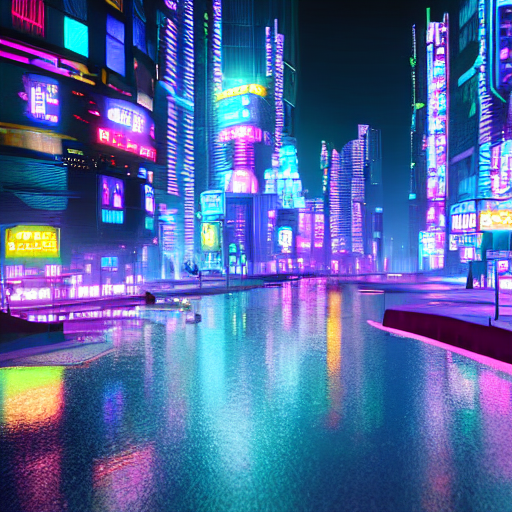

In [4]:
# 1. Decode
with torch.no_grad():
    # The VAE expects latents to be scaled by this constant
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample

# 2. Post-process (Scale to 0-255, Convert to PIL)
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")
final_image = Image.fromarray(image[0])

# 3. Display
display(final_image)

### Conclusion

You have successfully manually implemented the Stable Diffusion inference pipeline.

**Key Takeaways:**
1.  **Efficiency:** The U-Net never saw a $512 \times 512$ image. It only worked on small tensors ($64 \times 64$). The VAE handles the heavy lifting of high-res rendering.
2.  **Modularity:** You can swap the Scheduler (e.g., to EulerDiscrete) or the Text Encoder (to CLIP-L) independently because they are distinct components connected by the pipeline code.